In [1]:
# Notebook settings
%load_ext autoreload
%autoreload 2
# %matplotlib notebook
%config Completer.use_jedi = False

# SpikeInterface pipeline for Movshon Lab - OpenEphys

In [2]:
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
from pprint import pprint
import pytz

import spikeextractors as se
import spiketoolkit as st
import spikesorters as ss
import spikecomparison as sc
import spikewidgets as sw

## 1) Load recordings, compute LFP, and inspect signals

In [3]:
# Data files directory
# dir_path = Path('/home/luiz/storage/taufferconsulting/client_ben/project_movshon/movshon_data/oephys')
dir_path = Path('/home/luiz/storage/taufferconsulting/client_ben/project_movshon/movshon_data/expo/exampledata/expo_openephys/m666l3#7/openephys')

# Spikeinterface directory
dir_spikeinterface = dir_path / "spikeinterface"
dir_spikeinterface.mkdir(parents=True, exist_ok=True)
print(dir_spikeinterface)

# Create recording extractor
recording_0 = se.OpenEphysRecordingExtractor(folder_path=dir_path)

# Load probe info from .prb file
probe_file = dir_path / 'A32_ACDC.prb'
recording = recording_0.load_probe_file(probe_file=probe_file)

print()
print(f"Num channels: {recording.get_num_channels()}")
print(f"Sampling rate: {recording.get_sampling_frequency()}")
print(f"Duration (s): {recording.get_num_frames() / recording.get_sampling_frequency()}")

/home/luiz/storage/taufferconsulting/client_ben/project_movshon/movshon_data/expo/exampledata/expo_openephys/m666l3#7/openephys/spikeinterface
Loading Open-Ephys: reading settings...
Decoding data from  openephys  format

Num channels: 32
Sampling rate: 30000.0
Duration (s): 177.22026666666667


### Compute LFP

In [4]:
freq_min_lfp = 1
freq_max_lfp = 300
freq_resample_lfp = 1000.

# Apply bandpass filter
recording_lfp = st.preprocessing.bandpass_filter(
    recording=recording, 
    freq_min=freq_min_lfp, 
    freq_max=freq_max_lfp
)

# Resample lfp
recording_lfp = st.preprocessing.resample(
    recording=recording_lfp, 
    resample_rate=freq_resample_lfp,
)

print(f"Sampling frequency Raw: {recording.get_sampling_frequency()}")
print(f"Sampling frequency LF: {recording_lfp.get_sampling_frequency()}")   

Sampling frequency Raw: 30000.0
Sampling frequency LF: 1000.0


### Inspect signals

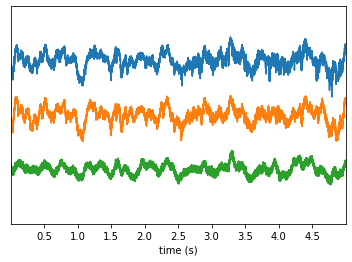

In [5]:
w_ts_raw = sw.plot_timeseries(recording, trange=[0, 5], channel_ids=[1, 2, 3])

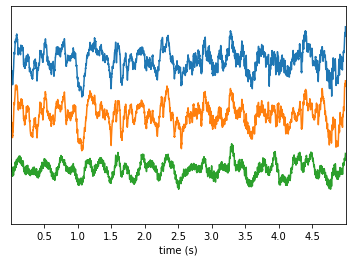

In [6]:
w_ts_lf = sw.plot_timeseries(recording_lfp, trange=[0, 5], channel_ids=[1, 2, 3])

## 2) Pre-processing
- Filters
- Common-reference removal
- Remove bad channels
- Remove stimulation artifacts

Ref: https://spikeinterface.readthedocs.io/en/latest/modules/toolkit/plot_1_preprocessing.html#preprocessing-tutorial

In [7]:
apply_filter = True
apply_cmr = True
freq_min_hp = 300
freq_max_hp = 3000

In [8]:
# Filtered recordings
if apply_filter:
    recording_processed = st.preprocessing.bandpass_filter(recording, freq_min=freq_min_hp, freq_max=freq_max_hp)
else:
    recording_processed = recording

if apply_cmr:
    recording_processed = st.preprocessing.common_reference(recording_processed)
    
# Stub recording for fast testing; set to False for running processing pipeline on entire data
stub_test = False
nsec_stub = 20
subr_ids = [i + 1 for i in range(31)]
if stub_test:
    recording_processed = se.SubRecordingExtractor(
        parent_recording=recording_processed, 
        channel_ids=subr_ids,
        end_frame=int(nsec_stub*recording_processed.get_sampling_frequency())
    )
    recording_lfp = se.SubRecordingExtractor(recording_lfp, end_frame=int(nsec_stub*recording_lfp.get_sampling_frequency()))
    
print(f"Original signal length: {recording.get_num_frames()}")
print(f"Processed signal length: {recording_processed.get_num_frames()}")

Original signal length: 5316608
Processed signal length: 5316608


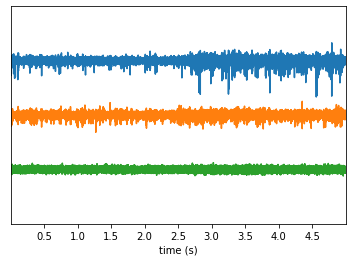

In [9]:
w_ts_processed = sw.plot_timeseries(recording_processed, trange=[0, 5], channel_ids=[1, 2, 3])

## 3) Run spike sorters

Ref: https://spikeinterface.readthedocs.io/en/latest/sortersinfo.html

In [10]:
ss.installed_sorters()

['herdingspikes', 'klusta', 'spykingcircus']

In [11]:
sorter_list = ['klusta', 'herdingspikes']

# Inspect sorter-specific parameters and defaults
for sorter in sorter_list:
    print(f"{sorter} params description:")
    pprint(ss.get_params_description(sorter))
    print("Default params:")
    pprint(ss.get_default_params(sorter))
    print()

klusta params description:
{'adjacency_radius': 'Radius in um to build channel neighborhood ',
 'chunk_mb': 'Chunk size in Mb for saving to binary format (default 500Mb)',
 'detect_sign': 'Use -1 (negative), 1 (positive) or 0 (both) depending on the '
                'sign of the spikes in the recording',
 'extract_s_after': 'Number of samples to cut out after the peak',
 'extract_s_before': 'Number of samples to cut out before the peak',
 'n_features_per_channel': 'Number of PCA features per channel',
 'n_jobs_bin': 'Number of jobs for saving to binary format (Default 1)',
 'num_starting_clusters': 'Number of initial clusters',
 'pca_n_waveforms_max': 'Maximum number of waveforms for PCA',
 'threshold_strong_std_factor': 'Strong threshold for spike detection',
 'threshold_weak_std_factor': 'Weak threshold for spike detection'}
Default params:
{'adjacency_radius': None,
 'chunk_mb': 500,
 'detect_sign': -1,
 'extract_s_after': 32,
 'extract_s_before': 16,
 'n_features_per_channel': 3,


In [12]:
# Choose which recording to use for sorting
rec_to_sort = recording_processed

# run sorting - Klusta
sorting_klusta = ss.run_klusta(
    recording=rec_to_sort, 
    output_folder=dir_spikeinterface / "si_output"
)

# run sorting - Herdingspikes
sorting_herding = ss.run_klusta(
    recording=rec_to_sort, 
    output_folder=dir_spikeinterface / "si_output"
)

print()
print(f'Klusta identified {len(sorting_herding.get_unit_ids())} units')
print(f'Herdingspikes identified {len(sorting_klusta.get_unit_ids())} units')

RUNNING SHELL SCRIPT: /home/luiz/storage/taufferconsulting/client_ben/project_movshon/movshon_data/expo/exampledata/expo_openephys/m666l3#7/openephys/spikeinterface/si_output/run_klusta.sh
RUNNING SHELL SCRIPT: /home/luiz/storage/taufferconsulting/client_ben/project_movshon/movshon_data/expo/exampledata/expo_openephys/m666l3#7/openephys/spikeinterface/si_output/run_klusta.sh

Klusta identified 58 units
Herdingspikes identified 57 units


## Multisorting comparison: get consensus-based ensemble results
Ref: https://spikeinterface.readthedocs.io/en/latest/modules/comparison/plot_2_compare_multiple_sorters.html?highlight=get_agreement_sorting#consensus-based-method

Ensamble sorting among ['klusta', 'herdingspikes'] found: 56 units


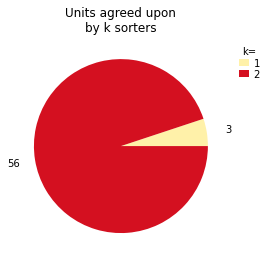

In [13]:
if len(sorter_list) > 1:       
    # run multisorting comparison
    mcmp = sc.compare_multiple_sorters(
        sorting_list=[sorting_klusta, sorting_herding], 
        name_list=sorter_list
    )
    
    # plot agreement results
    w_agr = sw.plot_multicomp_agreement(
        multi_sorting_comparison=mcmp,
        plot_type='pie',  #'bar'
    )
    
    # extract ensamble sorting
    sorting_ensemble = mcmp.get_agreement_sorting(minimum_agreement_count=2)
    
    print(f"Ensamble sorting among {sorter_list} found: {len(sorting_ensemble.get_unit_ids())} units")

In [14]:
# sorting to be used from here onwards
sorting = sorting_ensemble

## 4) Post-processing
- Compute spike waveforms
- Compute unit templates
- Compute extracellular features

Ref: https://spikeinterface.readthedocs.io/en/latest/modules/toolkit/plot_2_postprocessing.html

### Postprocess sorting results

In [15]:
# Post-processing params
postprocessing_params = st.postprocessing.get_common_params()
pprint(postprocessing_params)

OrderedDict([('max_spikes_per_unit', 300),
             ('recompute_info', False),
             ('save_property_or_features', True),
             ('memmap', True),
             ('seed', 0),
             ('verbose', False),
             ('joblib_backend', 'loky')])


In [16]:
# (optional) change parameters
postprocessing_params['max_spikes_per_unit'] = 1000  # with None, all waveforms are extracted

In [17]:
tmp_folder = dir_spikeinterface / 'tmp' / 'klusta'
tmp_folder.mkdir(parents=True, exist_ok=True)

# set local tmp folder
sorting.set_tmp_folder(tmp_folder)

# compute waveforms
waveforms = st.postprocessing.get_unit_waveforms(rec_to_sort, sorting, **postprocessing_params)

# compute templates
templates = st.postprocessing.get_unit_templates(rec_to_sort, sorting, **postprocessing_params)

# export to phy
phy_folder = dir_spikeinterface / 'phy' / 'klusta'
phy_folder.mkdir(parents=True, exist_ok=True)
st.postprocessing.export_to_phy(rec_to_sort, sorting, phy_folder)

Recomputing waveforms on all spikes


Text(0, 0.5, 'Avg spike trace per channel')

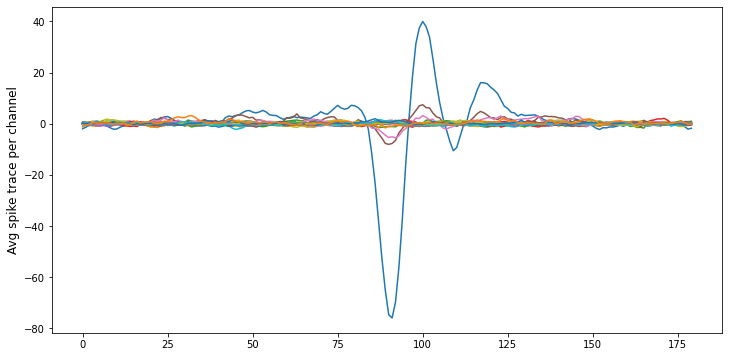

In [18]:
# Visualize spike template waverforms
unit_id = 1

plt.figure(figsize=(12, 6))
spk = np.squeeze(templates[unit_id])
plt.plot(spk.T)
plt.ylabel('Avg spike trace per channel', fontsize=12)

In [19]:
# Extracellular features
ec_list = st.postprocessing.get_template_features_list()
print(f"Available EC features: {ec_list}")

Available EC features: ['peak_to_valley', 'halfwidth', 'peak_trough_ratio', 'repolarization_slope', 'recovery_slope']


In [20]:
# (optional) define subset of ec
ec_list = ["peak_to_valley", "halfwidth"]

In [21]:
# comput EC features
ec = st.postprocessing.compute_unit_template_features(
    rec_to_sort, 
    sorting,
    feature_names=ec_list, 
    as_dataframe=True
)

ec.head()

,peak_to_valley,halfwidth
0,0.000300,0.000233
1,0.000300,0.000233
2,0.000267,0.000233
3,0.000300,0.000300
4,0.000300,0.000300


# 5) Automatic curation

You can automatically curate the spike sorting output using the quality metrics.

Ref: https://spikeinterface.readthedocs.io/en/latest/modules/toolkit/plot_4_curation.html

In [22]:
# st.validation.compute_quality_metrics?

# Quality metrics
qc_list = st.validation.get_quality_metrics_list()
print(f"Available quality metrics: {qc_list}")

Available quality metrics: ['num_spikes', 'firing_rate', 'presence_ratio', 'isi_violation', 'amplitude_cutoff', 'snr', 'max_drift', 'cumulative_drift', 'silhouette_score', 'isolation_distance', 'l_ratio', 'd_prime', 'noise_overlap', 'nn_hit_rate', 'nn_miss_rate']


In [23]:
# (optional) define subset of qc
qc_list = ["snr", "isi_violation", "firing_rate"]

In [24]:
# compute quality metrics
qc = st.validation.compute_quality_metrics(
    sorting=sorting, 
    recording=rec_to_sort, 
    metric_names=qc_list, 
    as_dataframe=True
)

qc.head(10)

,firing_rate,isi_violation,snr
0,1.224465,12.686013,7.780794
1,1.591240,3.755921,9.195101
2,13.141838,0.374442,9.228343
3,9.987571,0.000000,20.495142
4,7.454001,4.518694,7.398065
5,2.759278,9.742974,7.781967
6,0.564270,5.973717,5.709212
7,0.823834,22.419654,4.569928
8,13.401402,0.180039,10.279045
9,6.765592,1.080388,4.132238


In [25]:
# define curators and thresholds
firing_rate_threshold = 0.1
isi_violation_threshold = 0.6
snr_threshold = 4

In [26]:
num_frames = rec_to_sort.get_num_frames()

# firing rate threshold
sorting_curated = st.curation.threshold_firing_rates(
    sorting,
    duration_in_frames=num_frames,
    threshold=firing_rate_threshold, 
    threshold_sign='less'
)

# isi violation threshold
sorting_curated = st.curation.threshold_isi_violations(
    sorting_curated,
    duration_in_frames=num_frames,
    threshold=isi_violation_threshold, 
    threshold_sign='greater'
)

# isi violation threshold
sorting_curated = st.curation.threshold_snrs(
    sorting_curated,
    recording=rec_to_sort,
    threshold=snr_threshold, 
    threshold_sign='less'
)

In [27]:
print(f'Number of sorted units before curation: {len(sorting.get_unit_ids())}')
print(f'Number of sorted units after curation: {len(sorting_curated.get_unit_ids())}')

Number of sorted units before curation: 56
Number of sorted units after curation: 17


# 6) Quick save to NWB using Spikeinterface

Ref: https://pynwb.readthedocs.io/en/stable/pynwb.file.html#pynwb.file.NWBFile

In [28]:
# Save results to NWB file
output_nwb = 'openephys_si_results.nwb'

# Add customized Metadata info - Optional
session_start_time = recording_0._fileobj.experiments[0].datetime
session_start_time_tzaware = pytz.timezone('EST').localize(session_start_time)

metadata = se.NwbRecordingExtractor.get_nwb_metadata(recording=rec_to_sort)
metadata['NWBFile'].update(
    session_start_time=session_start_time_tzaware,
    session_description='a detailed description of this experimental session...',
    institution='NYU',
    lab='Movshon lab',
    pharmacology='Description of drugs used',
    experimenter=['Person1', 'Person2'],
    keywords=['openephys', 'tutorial', 'etc']
)
metadata['Ecephys']['Device'][0].update(description='a detailed description of this device')

# Write voltage traces data
se.NwbRecordingExtractor.write_recording(
    recording=rec_to_sort,
    save_path=output_nwb,
    overwrite=True,
    metadata=metadata
)

# Write spiking data
se.NwbSortingExtractor.write_sorting(
    sorting=sorting,
    save_path=output_nwb,
    overwrite=False
)

Skipping property 'sorter_unit_ids' because dictionaries are not supported.


/media/luiz/storage/Github/spikeextractors/spikeextractors/extractors/nwbextractors/nwbextractors.py:1265: UserWarning: Description for property agreement_number not found in property_descriptions. Setting description to 'no description'
  f"Description for property {pr} not found in property_descriptions. "
/media/luiz/storage/Github/spikeextractors/spikeextractors/extractors/nwbextractors/nwbextractors.py:1265: UserWarning: Description for property waveforms_channel_idxs not found in property_descriptions. Setting description to 'no description'
  f"Description for property {pr} not found in property_descriptions. "
/media/luiz/storage/Github/spikeextractors/spikeextractors/extractors/nwbextractors/nwbextractors.py:1265: UserWarning: Description for property pca_scores_channel_idxs not found in property_descriptions. Setting description to 'no description'
  f"Description for property {pr} not found in property_descriptions. "
/media/luiz/storage/Github/spikeextractors/spikeextractor

In [29]:
# Check NWB file with widgets
from pynwb import NWBFile, NWBHDF5IO
from nwbwidgets import nwb2widget

io = NWBHDF5IO(output_nwb, 'r')
nwbfile = io.read()
nwb2widget(nwbfile)

In [30]:
io.close()

# 7) Include Expo trials with NWB conversion tools

In [31]:
from movshon_lab_to_nwb import MovshonExpoNWBConverter

In [32]:
# Source data
base_path = Path('/home/luiz/storage/taufferconsulting/client_ben/project_movshon/movshon_data/expo/exampledata/expo_openephys/m666l3#7')

expo_file = base_path / 'm666l3#7[ori16].xml'
ttl_file = base_path / 'openephys/100_ADC1.continuous'

source_data = dict(
    ExpoDataInterface=dict(
        expo_file=str(expo_file),
        ttl_file=str(ttl_file)
    )
)

# Initialize converter
converter = MovshonExpoNWBConverter(source_data=source_data)

# Conversion options
conversion_options = dict(
    ExpoDataInterface=dict(convert_expo=True)
)

converter.run_conversion(
    metadata={},
    nwbfile_path=output_nwb, 
    overwrite=False,
    conversion_options=conversion_options
)

Adding expo data...
Trials sync offset: 2.7647
NWB file saved at openephys_si_results.nwb!


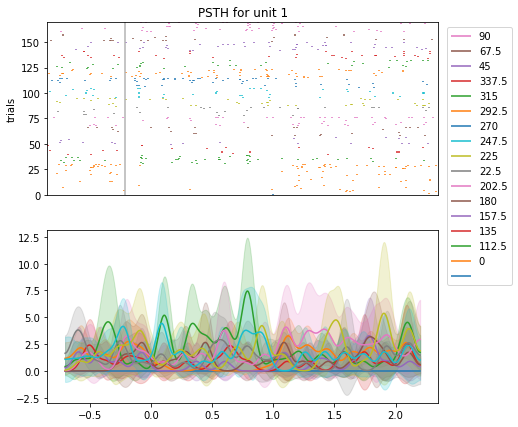

In [35]:
io = NWBHDF5IO(output_nwb, 'r')
nwbfile = io.read()
nwb2widget(nwbfile)

In [34]:
io.close()